
Simulating for m=1.05


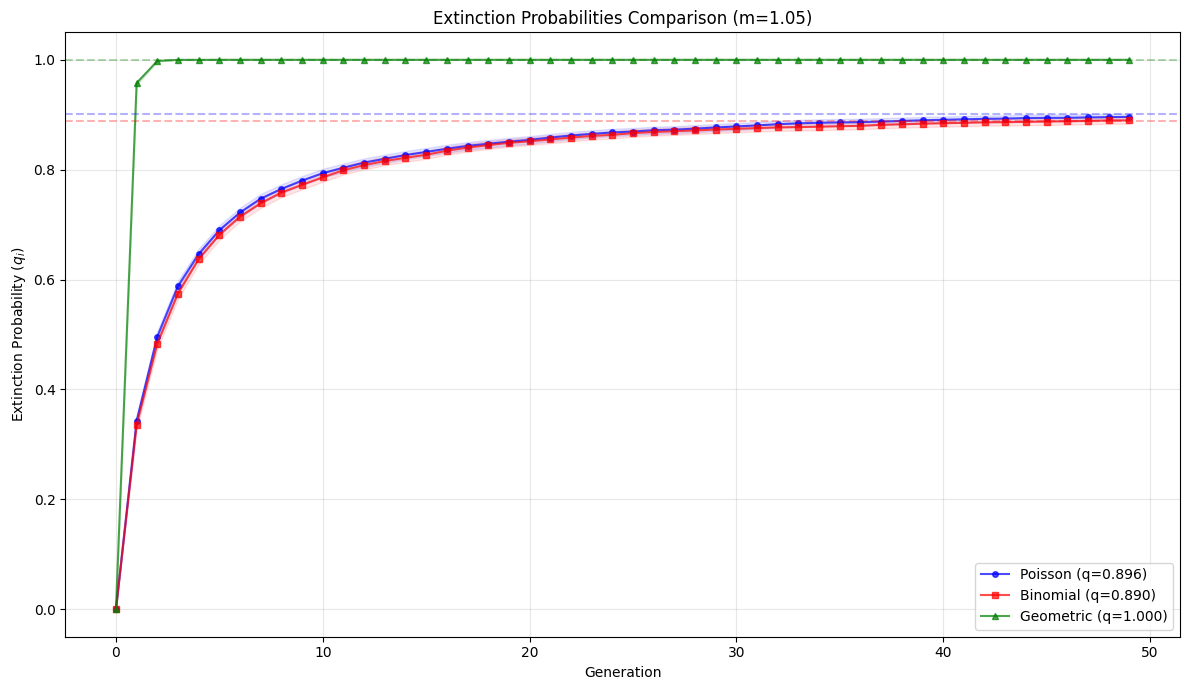


Simulating for m=1.1


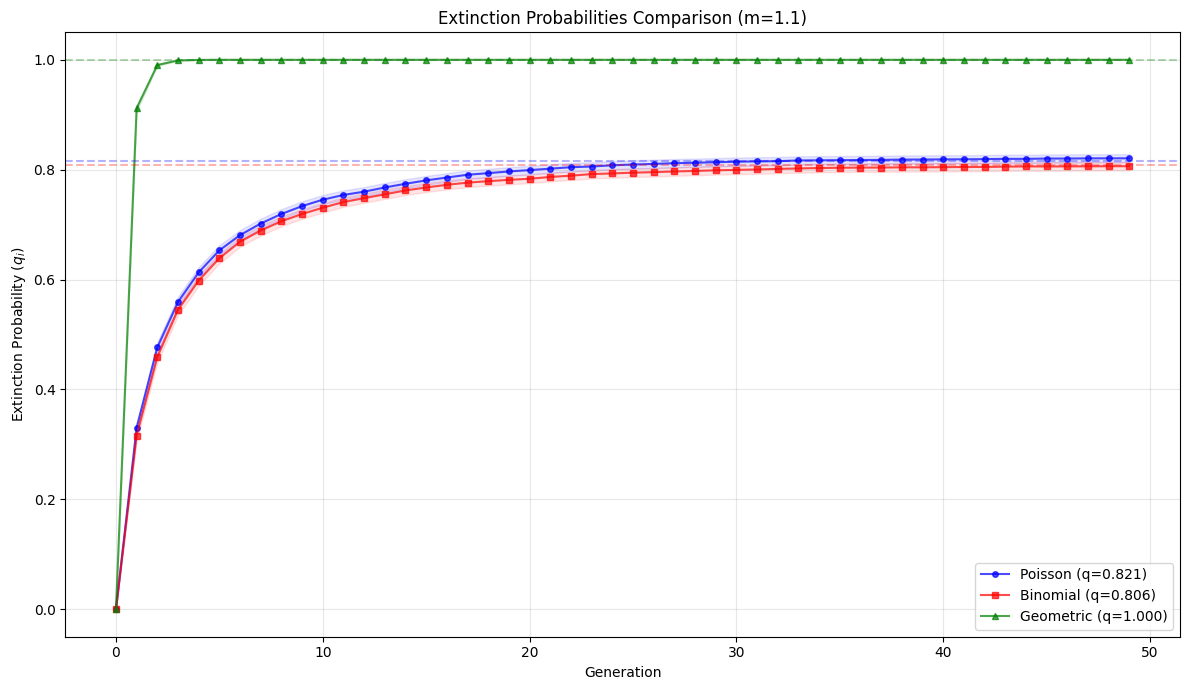

In [1]:
import numpy as np
from scipy.stats import poisson, binom, geom, norm
import matplotlib.pyplot as plt

def galton_watson_simulation(Y_v, m, N=10000, max_generations=50):
    """
    Simulate the Galton-Watson process for extinction probabilities and population sizes.
    """
    def sample_offspring(Y_v, m):
        if Y_v == "poisson":
            return np.random.poisson(m)
        elif Y_v == "binomial":
            return np.random.binomial(10, m / 10)
        elif Y_v == "geometric":
            return np.random.geometric(1 / m) - 1  # Zero-indexed
        else:
            raise ValueError("Unsupported offspring distribution")
    
    extinction_counts = np.zeros(max_generations)
    population_sizes = np.zeros((N, max_generations))
    
    for sim in range(N):
        Z = 1  # Start with one ancestor
        for gen in range(max_generations):
            population_sizes[sim, gen] = Z
            if Z == 0:
                extinction_counts[gen:] += 1
                break
            Z = sum(sample_offspring(Y_v, m) for _ in range(int(Z)))
    
    # Estimate q_i and q
    qi = extinction_counts / N
    q = qi[-1]
    
    # Compute confidence intervals
    z = norm.ppf(0.975)  # 95% CI
    ci = [
        (q_gen - z * np.sqrt(q_gen * (1 - q_gen) / N),
         q_gen + z * np.sqrt(q_gen * (1 - q_gen) / N)) 
        for q_gen in qi
    ]
    
    return qi, q, ci, population_sizes

def plot_extinction_comparison(Y_v_list, m, N=10000, max_generations=50):
    """
    Plot extinction probabilities for different distributions in one graph.
    """
    plt.figure(figsize=(12, 7))
    
    colors = ['blue', 'red', 'green']  # Different color for each distribution
    styles = ['-o', '-s', '-^']  # Different marker styles
    
    for Y_v, color, style in zip(Y_v_list, colors, styles):
        qi, q, ci, _ = galton_watson_simulation(Y_v, m, N, max_generations)
        generations = np.arange(len(qi))
        
        # Plot main line with markers
        plt.plot(generations, qi, style, color=color, 
                label=f"{Y_v.capitalize()} (q={q:.3f})", 
                markersize=4, alpha=0.7)
        
        # Plot confidence intervals
        lower_ci = [c[0] for c in ci]
        upper_ci = [c[1] for c in ci]
        plt.fill_between(generations, lower_ci, upper_ci, 
                        color=color, alpha=0.1)
    
    plt.title(f"Extinction Probabilities Comparison (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Extinction Probability ($q_i$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.05, 1.05)  # Set y-axis limits for better visualization
    
    # Add horizontal line at q value for each distribution
    for Y_v, color in zip(Y_v_list, colors):
        qi, q, _, _ = galton_watson_simulation(Y_v, m, N, max_generations)
        plt.axhline(y=q, color=color, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage
Y_v_list = ["poisson", "binomial", "geometric"]
m_values = [1.05, 1.1]

for m in m_values:
    print(f"\nSimulating for m={m}")
    plot_extinction_comparison(Y_v_list, m)

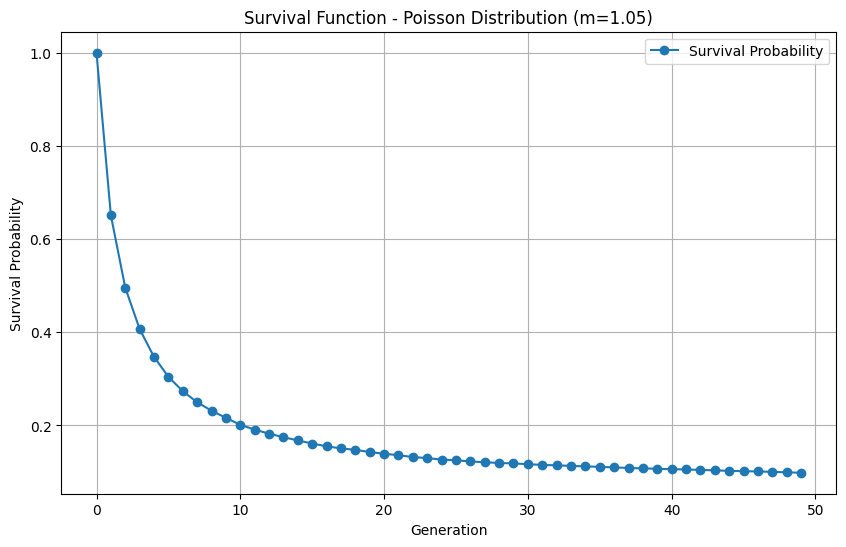

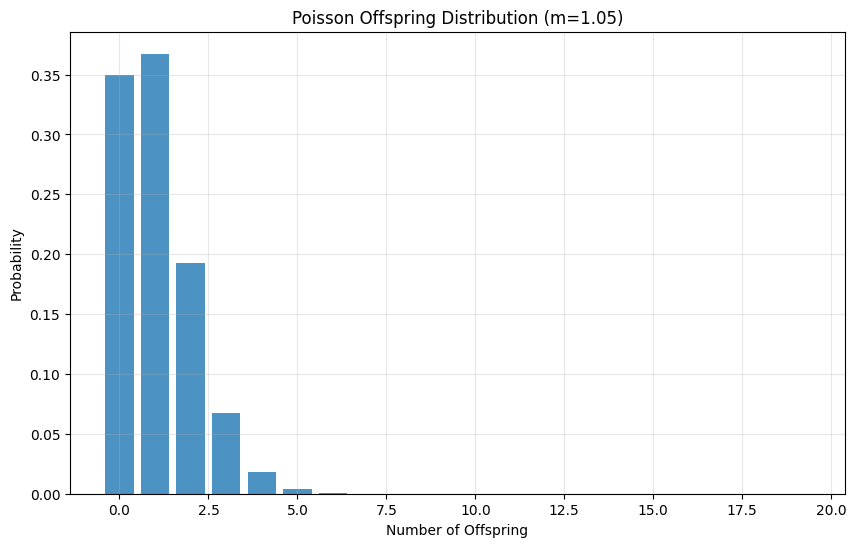

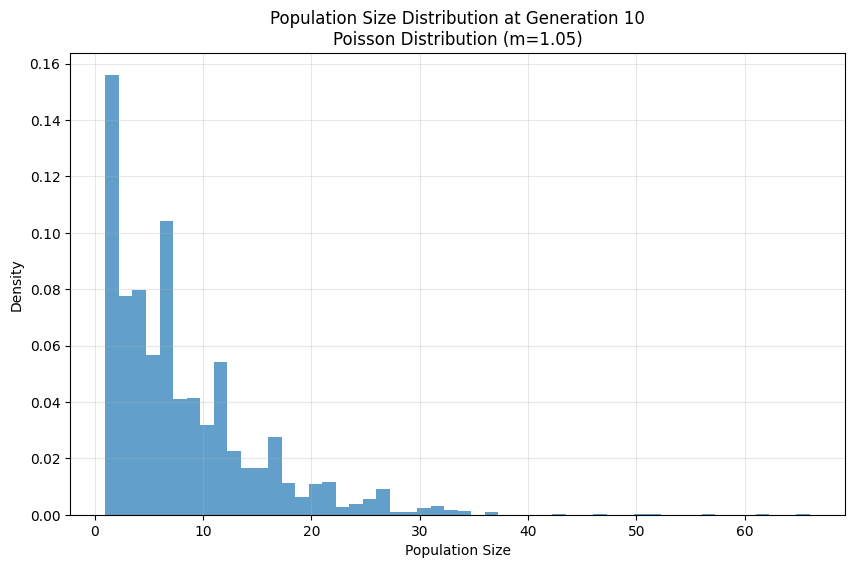

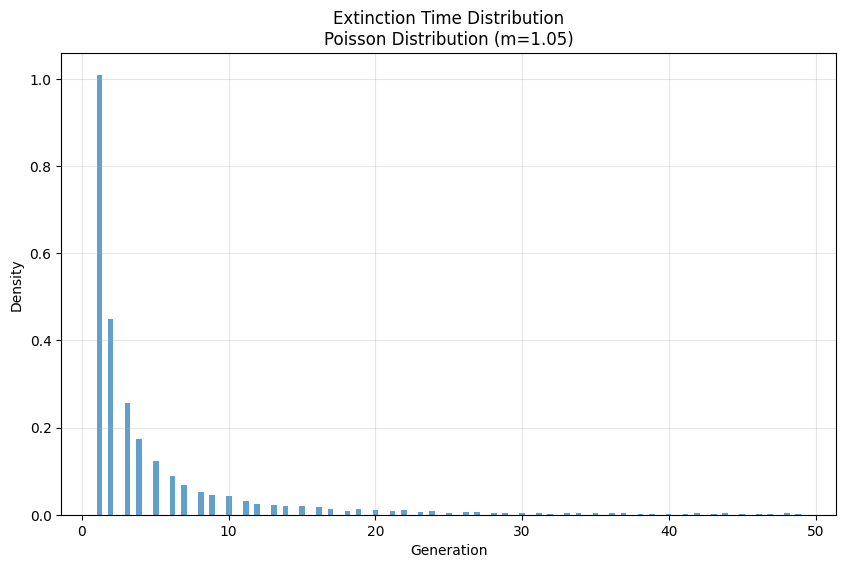

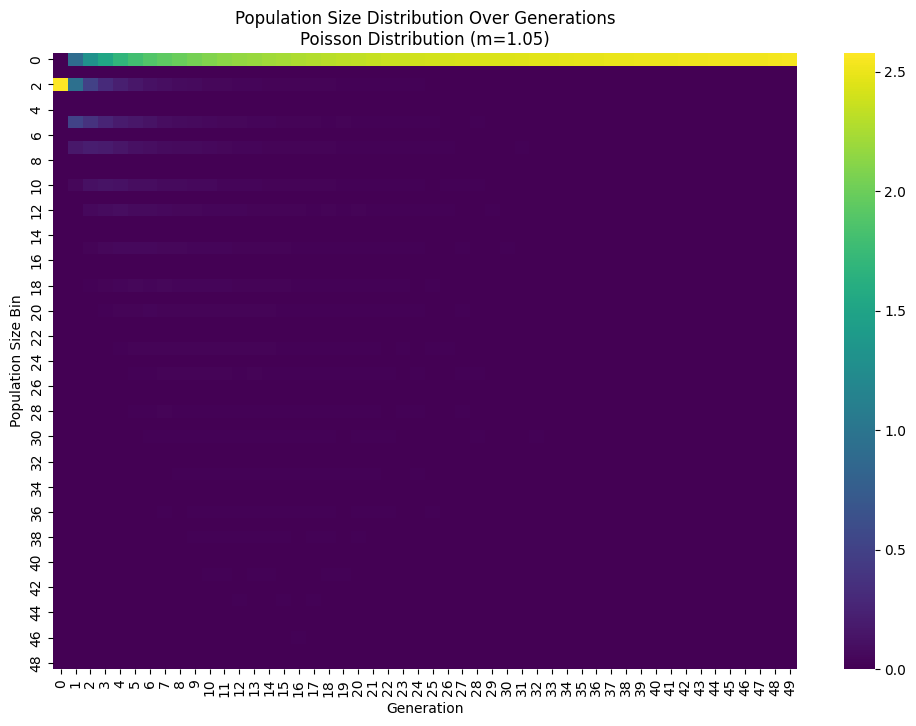

In [5]:
import numpy as np
from scipy.stats import poisson, binom, geom, norm
import matplotlib.pyplot as plt
import seaborn as sns

def plot_survival_function(population_sizes, Y_v, m):
    """
    Plot the survival function (1 - extinction probability) over generations.
    """
    survival_prob = 1 - np.mean(population_sizes == 0, axis=0)
    generations = np.arange(len(survival_prob))
    
    plt.figure(figsize=(10, 6))
    plt.plot(generations, survival_prob, label="Survival Probability", marker='o')
    plt.title(f"Survival Function - {Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.grid()
    plt.show()

def plot_offspring_distribution(Y_v, m, max_offspring=20):
    """
    Plot the theoretical offspring distribution.
    """
    x = np.arange(max_offspring)
    if Y_v == "poisson":
        pmf = poisson.pmf(x, m)
        dist_name = "Poisson"
    elif Y_v == "binomial":
        pmf = binom.pmf(x, 10, m/10)
        dist_name = "Binomial"
    elif Y_v == "geometric":
        pmf = geom.pmf(x + 1, 1/m)  # Add 1 since we're zero-indexed
        dist_name = "Geometric"
    
    plt.figure(figsize=(10, 6))
    plt.bar(x, pmf, alpha=0.8)
    plt.title(f"{dist_name} Offspring Distribution (m={m})")
    plt.xlabel("Number of Offspring")
    plt.ylabel("Probability")
    plt.grid(alpha=0.3)
    plt.show()

def plot_generation_histogram(population_sizes, generation, Y_v, m):
    """
    Plot histogram of population sizes at a specific generation.
    """
    non_zero_pop = population_sizes[:, generation][population_sizes[:, generation] > 0]
    
    plt.figure(figsize=(10, 6))
    plt.hist(non_zero_pop, bins='auto', density=True, alpha=0.7)
    plt.title(f"Population Size Distribution at Generation {generation}\n{Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Population Size")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    plt.show()

def plot_extinction_time_distribution(population_sizes, Y_v, m):
    """
    Plot the distribution of extinction times for processes that went extinct.
    """
    extinction_times = []
    for sim in population_sizes:
        # Find the first occurrence of 0 in the simulation
        zero_indices = np.where(sim == 0)[0]
        if len(zero_indices) > 0:
            extinction_times.append(zero_indices[0])
    
    if extinction_times:
        plt.figure(figsize=(10, 6))
        plt.hist(extinction_times, bins='auto', density=True, alpha=0.7)
        plt.title(f"Extinction Time Distribution\n{Y_v.capitalize()} Distribution (m={m})")
        plt.xlabel("Generation")
        plt.ylabel("Density")
        plt.grid(alpha=0.3)
        plt.show()

def plot_heatmap(population_sizes, Y_v, m):
    """
    Create a heatmap showing the distribution of population sizes over generations.
    """
    # Create bins for population sizes
    max_pop = np.percentile(population_sizes, 95)  # Use 95th percentile to avoid outlier effects
    bins = np.linspace(0, max_pop, 50)
    
    # Calculate histogram for each generation
    heatmap_data = np.zeros((len(bins)-1, population_sizes.shape[1]))
    for gen in range(population_sizes.shape[1]):
        heatmap_data[:, gen], _ = np.histogram(population_sizes[:, gen], bins=bins, density=True)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='viridis')
    plt.title(f"Population Size Distribution Over Generations\n{Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Population Size Bin")
    plt.show()

# Example usage:
def create_all_plots(Y_v, m, N=10000, max_generations=50):
    """
    Create all plots for a given distribution and mean offspring number.
    """
    # Run simulation
    qi, q, ci, population_sizes = galton_watson_simulation(Y_v, m, N, max_generations)
    
    # Create all plots
    plot_survival_function(population_sizes, Y_v, m)
    plot_offspring_distribution(Y_v, m)
    plot_generation_histogram(population_sizes, 10, Y_v, m)
    plot_extinction_time_distribution(population_sizes, Y_v, m)
    plot_heatmap(population_sizes, Y_v, m)

# Example usage:
create_all_plots("poisson", 1.05)

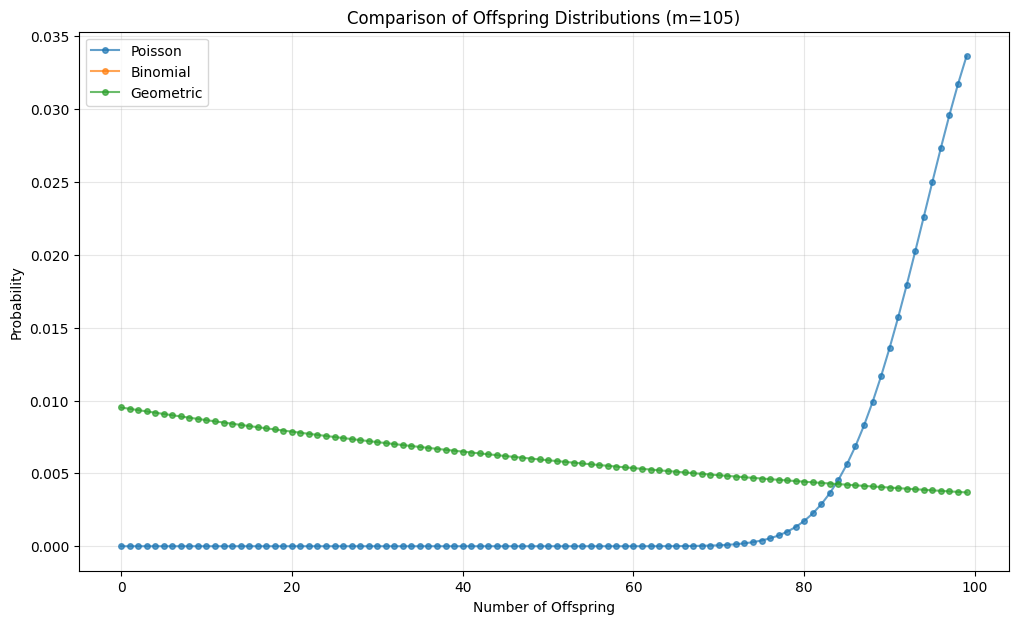

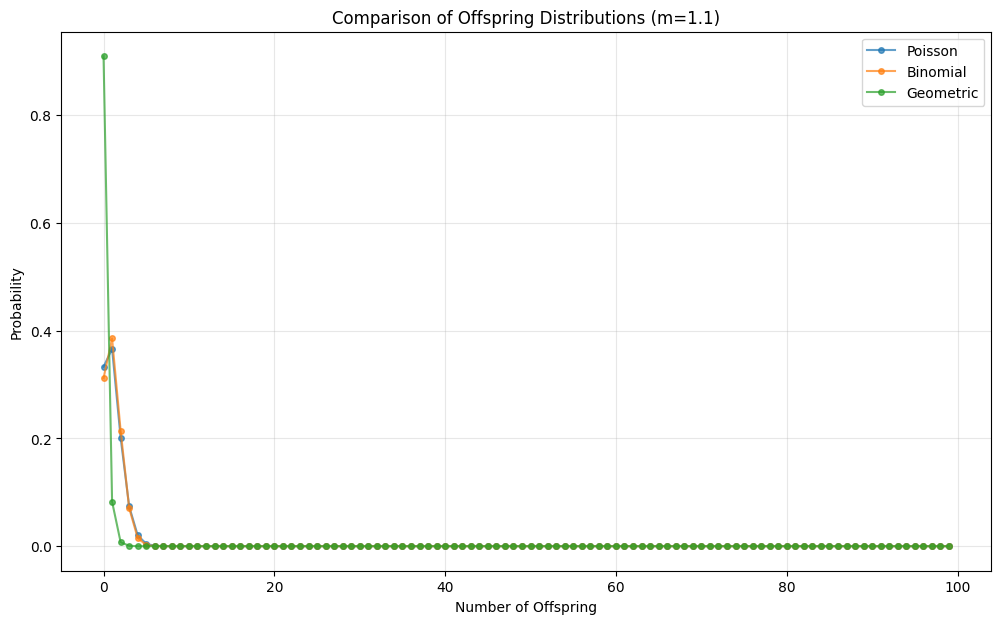

In [12]:
import numpy as np
from scipy.stats import poisson, binom, geom, norm
import matplotlib.pyplot as plt
import seaborn as sns

def plot_survival_function(population_sizes, Y_v, m):
    """
    Plot the survival function (1 - extinction probability) over generations.
    """
    survival_prob = 1 - np.mean(population_sizes == 0, axis=0)
    generations = np.arange(len(survival_prob))
    
    plt.figure(figsize=(10, 6))
    plt.plot(generations, survival_prob, label="Survival Probability", marker='o')
    plt.title(f"Survival Function - {Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.grid()
    plt.show()

def plot_all_offspring_distributions(m, max_offspring=100):
    """
    Plot all theoretical offspring distributions in one figure for comparison.
    """
    x = np.arange(max_offspring)
    distributions = {
        "Poisson": lambda x: poisson.pmf(x, m),
        "Binomial": lambda x: binom.pmf(x, 10, m/10),
        "Geometric": lambda x: geom.pmf(x + 1, 1/m)  # Add 1 since we're zero-indexed
    }
    
    plt.figure(figsize=(12, 7))
    
    for idx, (dist_name, pmf_func) in enumerate(distributions.items()):
        pmf = pmf_func(x)
        plt.plot(x, pmf, marker='o', label=dist_name, alpha=0.7, markersize=4)
    
    plt.title(f"Comparison of Offspring Distributions (m={m})")
    plt.xlabel("Number of Offspring")
    plt.ylabel("Probability")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

def plot_offspring_distribution(Y_v, m, max_offspring=20):
    """
    Plot the theoretical offspring distribution for a single distribution type.
    """
    x = np.arange(max_offspring)
    if Y_v == "poisson":
        pmf = poisson.pmf(x, m)
        dist_name = "Poisson"
    elif Y_v == "binomial":
        pmf = binom.pmf(x, 10, m/10)
        dist_name = "Binomial"
    elif Y_v == "geometric":
        pmf = geom.pmf(x + 1, 1/m)  # Add 1 since we're zero-indexed
        dist_name = "Geometric"
    
    plt.figure(figsize=(10, 6))
    plt.bar(x, pmf, alpha=0.8)
    plt.title(f"{dist_name} Offspring Distribution (m={m})")
    plt.xlabel("Number of Offspring")
    plt.ylabel("Probability")
    plt.grid(alpha=0.3)
    plt.show()

def plot_generation_histogram(population_sizes, generation, Y_v, m):
    """
    Plot histogram of population sizes at a specific generation.
    """
    non_zero_pop = population_sizes[:, generation][population_sizes[:, generation] > 0]
    
    plt.figure(figsize=(10, 6))
    plt.hist(non_zero_pop, bins='auto', density=True, alpha=0.7)
    plt.title(f"Population Size Distribution at Generation {generation}\n{Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Population Size")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    plt.show()

def plot_extinction_time_distribution(population_sizes, Y_v, m):
    """
    Plot the distribution of extinction times for processes that went extinct.
    """
    extinction_times = []
    for sim in population_sizes:
        # Find the first occurrence of 0 in the simulation
        zero_indices = np.where(sim == 0)[0]
        if len(zero_indices) > 0:
            extinction_times.append(zero_indices[0])
    
    if extinction_times:
        plt.figure(figsize=(10, 6))
        plt.hist(extinction_times, bins='auto', density=True, alpha=0.7)
        plt.title(f"Extinction Time Distribution\n{Y_v.capitalize()} Distribution (m={m})")
        plt.xlabel("Generation")
        plt.ylabel("Density")
        plt.grid(alpha=0.3)
        plt.show()

def plot_heatmap(population_sizes, Y_v, m):
    """
    Create a heatmap showing the distribution of population sizes over generations.
    """
    # Create bins for population sizes
    max_pop = np.percentile(population_sizes, 95)  # Use 95th percentile to avoid outlier effects
    bins = np.linspace(0, max_pop, 50)
    
    # Calculate histogram for each generation
    heatmap_data = np.zeros((len(bins)-1, population_sizes.shape[1]))
    for gen in range(population_sizes.shape[1]):
        heatmap_data[:, gen], _ = np.histogram(population_sizes[:, gen], bins=bins, density=True)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='viridis')
    plt.title(f"Population Size Distribution Over Generations\n{Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Population Size Bin")
    plt.show()

# Example usage:
def create_all_plots(Y_v, m, N=10000, max_generations=50):
    """
    Create all plots for a given distribution and mean offspring number.
    """
    # Run simulation
    qi, q, ci, population_sizes = galton_watson_simulation(Y_v, m, N, max_generations)
    
    # Plot combined offspring distributions
    plot_all_offspring_distributions(m=105)
    plot_all_offspring_distributions(m=1.1)

# Example usage:
create_all_plots("poisson", 1.1)

/Users/erfanbayat/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erfanbayat/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


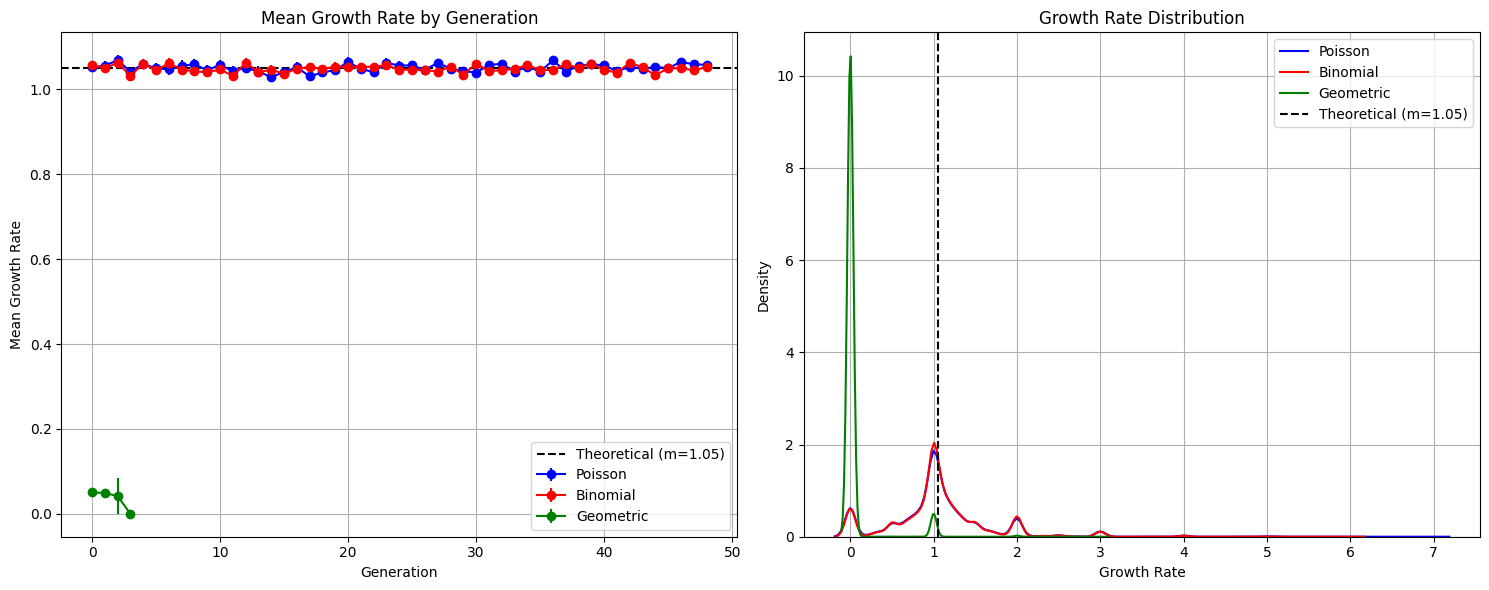


Statistical Summary:
--------------------------------------------------

Poisson Distribution:
Mean Growth Rate: 1.052 ± 0.616
T-statistic vs m=1.05: 0.944
P-value: 3.454e-01

Binomial Distribution:
Mean Growth Rate: 1.050 ± 0.581
T-statistic vs m=1.05: 0.067
P-value: 9.466e-01

Geometric Distribution:
Mean Growth Rate: 0.050 ± 0.230
T-statistic vs m=1.05: -444.844
P-value: 0.000e+00


/Users/erfanbayat/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erfanbayat/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


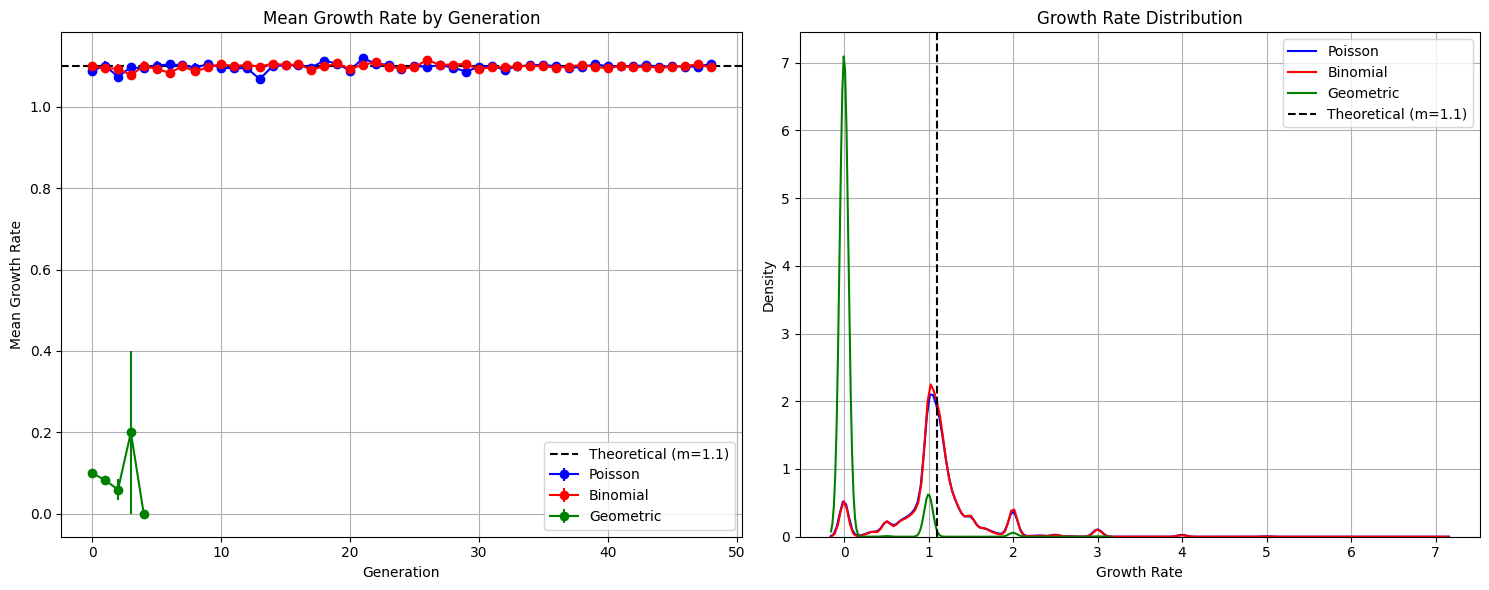


Statistical Summary:
--------------------------------------------------

Poisson Distribution:
Mean Growth Rate: 1.097 ± 0.549
T-statistic vs m=1.1: -1.812
P-value: 6.996e-02

Binomial Distribution:
Mean Growth Rate: 1.098 ± 0.514
T-statistic vs m=1.1: -1.562
P-value: 1.183e-01

Geometric Distribution:
Mean Growth Rate: 0.098 ± 0.328
T-statistic vs m=1.1: -319.897
P-value: 0.000e+00


In [10]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_growth_rates(population_sizes):
    """
    Calculate generation-to-generation growth rates for non-extinct populations.
    
    Args:
        population_sizes: Array of shape (n_simulations, n_generations)
    Returns:
        growth_rates: Array of growth rates
        generations: Corresponding generation numbers
    """
    n_sims, n_gens = population_sizes.shape
    growth_rates = []
    generations = []
    
    for gen in range(n_gens - 1):
        # Consider only non-extinct populations in current generation
        mask = population_sizes[:, gen] > 0
        current_pop = population_sizes[mask, gen]
        next_pop = population_sizes[mask, gen + 1]
        
        # Calculate rates only where current population is non-zero
        valid_rates = next_pop / current_pop
        growth_rates.extend(valid_rates)
        generations.extend([gen] * len(valid_rates))
    
    return np.array(growth_rates), np.array(generations)

def analyze_growth_rates(population_sizes, m, distribution_name):
    """
    Perform statistical analysis of growth rates.
    """
    growth_rates, generations = calculate_growth_rates(population_sizes)
    
    # Overall statistics
    mean_rate = np.mean(growth_rates)
    std_rate = np.std(growth_rates)
    
    # T-test against theoretical mean m
    t_stat, p_value = stats.ttest_1samp(growth_rates, m)
    
    # Generation-wise statistics
    unique_gens = np.unique(generations)
    gen_means = [np.mean(growth_rates[generations == gen]) for gen in unique_gens]
    gen_sems = [stats.sem(growth_rates[generations == gen]) for gen in unique_gens]
    
    return {
        'distribution': distribution_name,
        'mean_rate': mean_rate,
        'std_rate': std_rate,
        't_stat': t_stat,
        'p_value': p_value,
        'gen_means': np.array(gen_means),
        'gen_sems': np.array(gen_sems),
        'generations': unique_gens,
        'all_rates': growth_rates,
        'all_gens': generations
    }

def plot_growth_rate_comparison(analysis_results, m):
    """
    Create comparative plots for growth rates across different distributions.
    """
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different distributions
    colors = {'poisson': 'blue', 'binomial': 'red', 'geometric': 'green'}
    
    # Plot 1: Generation-wise mean growth rates
    for result in analysis_results:
        dist = result['distribution']
        ax1.errorbar(result['generations'], result['gen_means'], 
                    yerr=result['gen_sems'], label=f"{dist.capitalize()}", 
                    color=colors[dist], marker='o')
    
    ax1.axhline(y=m, color='black', linestyle='--', label=f'Theoretical (m={m})')
    ax1.set_title('Mean Growth Rate by Generation')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Mean Growth Rate')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Growth rate distributions
    for result in analysis_results:
        dist = result['distribution']
        sns.kdeplot(data=result['all_rates'], label=f"{dist.capitalize()}", 
                   ax=ax2, color=colors[dist])
    
    ax2.axvline(x=m, color='black', linestyle='--', label=f'Theoretical (m={m})')
    ax2.set_title('Growth Rate Distribution')
    ax2.set_xlabel('Growth Rate')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical summary
    print("\nStatistical Summary:")
    print("-" * 50)
    for result in analysis_results:
        print(f"\n{result['distribution'].capitalize()} Distribution:")
        print(f"Mean Growth Rate: {result['mean_rate']:.3f} ± {result['std_rate']:.3f}")
        print(f"T-statistic vs m={m}: {result['t_stat']:.3f}")
        print(f"P-value: {result['p_value']:.3e}")

# Example usage:
def run_growth_analysis(Y_v_list, m_values):
    for m in m_values:
        results = []
        for Y_v in Y_v_list:
            # Run simulation using existing galton_watson_simulation function
            _, _, _, population_sizes = galton_watson_simulation(Y_v, m)
            results.append(analyze_growth_rates(population_sizes, m, Y_v))
        
        # Plot comparative results
        plot_growth_rate_comparison(results, m)
Y_v_list = ["poisson", "binomial", "geometric"]
m_values = [1.05, 1.1]
run_growth_analysis(Y_v_list, m_values)

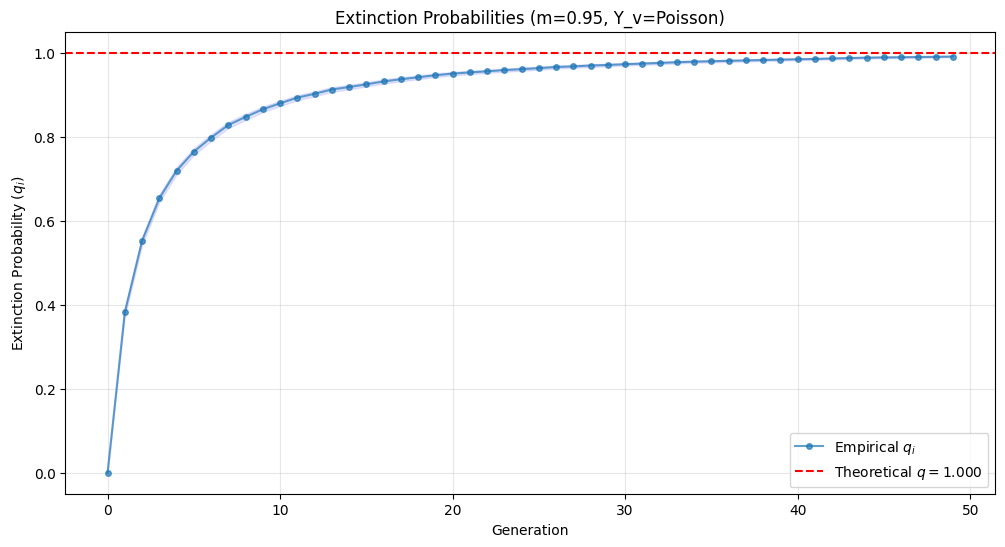

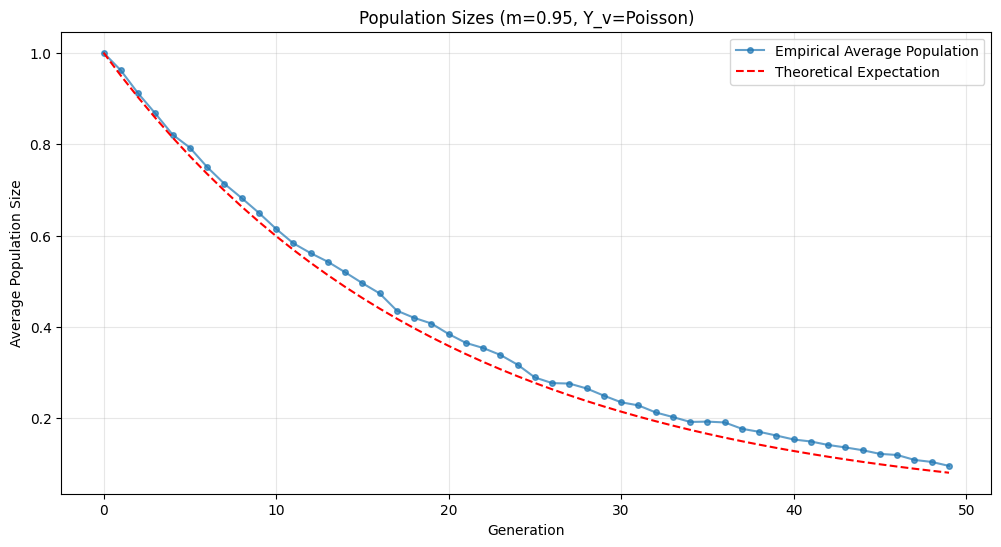

In [13]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fixed_point
import matplotlib.pyplot as plt

def galton_watson_simulation(Y_v, m, N=10000, max_generations=50):
    """
    Simulate the Galton-Watson process for extinction probabilities and population sizes.
    """
    def sample_offspring(Y_v, m):
        if Y_v == "poisson":
            return np.random.poisson(m)
        elif Y_v == "binomial":
            return np.random.binomial(10, m / 10)
        elif Y_v == "geometric":
            return np.random.geometric(1 / m) - 1  # Zero-indexed
        else:
            raise ValueError("Unsupported offspring distribution")
    
    extinction_counts = np.zeros(max_generations)
    population_sizes = np.zeros((N, max_generations))
    
    for sim in range(N):
        Z = 1  # Start with one ancestor
        for gen in range(max_generations):
            population_sizes[sim, gen] = Z
            if Z == 0:
                extinction_counts[gen:] += 1
                break
            Z = sum(sample_offspring(Y_v, m) for _ in range(int(Z)))
    
    # Estimate q_i and q
    qi = extinction_counts / N
    q = qi[-1]
    
    # Compute confidence intervals
    z = norm.ppf(0.975)  # 95% CI
    ci = [
        (q_gen - z * np.sqrt(q_gen * (1 - q_gen) / N),
         q_gen + z * np.sqrt(q_gen * (1 - q_gen) / N)) 
        for q_gen in qi
    ]
    
    return qi, q, ci, population_sizes

def theoretical_extinction_probability(m):
    """
    Solve q = e^(-m * (1 - q)) numerically for theoretical extinction probability.
    """
    return fixed_point(lambda q: np.exp(-m * (1 - q)), 0.5)

# Set parameters
m = 0.95
N = 10000
max_generations = 50
Y_v = "poisson"

# Simulate the Galton-Watson process
qi, q_empirical, ci, population_sizes = galton_watson_simulation(Y_v, m, N, max_generations)

# Theoretical predictions
q_theoretical = theoretical_extinction_probability(m)
expected_population_sizes = [m**n for n in range(max_generations)]

# Plot extinction probabilities
generations = np.arange(max_generations)
plt.figure(figsize=(12, 6))

# Empirical extinction probabilities
plt.plot(generations, qi, 'o-', label="Empirical $q_i$", markersize=4, alpha=0.7)

# Theoretical extinction probability
plt.axhline(y=q_theoretical, color='red', linestyle='--', label=f"Theoretical $q={q_theoretical:.3f}$")

# Add confidence intervals
lower_ci = [c[0] for c in ci]
upper_ci = [c[1] for c in ci]
plt.fill_between(generations, lower_ci, upper_ci, color='blue', alpha=0.1)

plt.title(f"Extinction Probabilities (m={m}, Y_v=Poisson)")
plt.xlabel("Generation")
plt.ylabel("Extinction Probability ($q_i$)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot population sizes
avg_population_sizes = population_sizes.mean(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(generations, avg_population_sizes, 'o-', label="Empirical Average Population", markersize=4, alpha=0.7)
plt.plot(generations, expected_population_sizes, '--', label="Theoretical Expectation", color='red')

plt.title(f"Population Sizes (m={m}, Y_v=Poisson)")
plt.xlabel("Generation")
plt.ylabel("Average Population Size")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
